In [1]:
import os, random
import torch
import torch.nn.functional as F 

from pathlib import Path
from PIL import Image
from transformers import (
                            TrOCRProcessor, 
                            VisionEncoderDecoderModel)

/Users/nestornavarro/.pyenv/versions/3.12.7/envs/svit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<figure>
  <img
  src="https://chamber.ua/wp-content/uploads/2020/01/SvSys_Logo.png"
  alt="svilta logo."
  width=550>
  <h1>Nestor Navarro ML Take home</h1>
</figure>

# Quick Data Revision

Auxiliary functions used in data exploration and possibly later in model discovery.

In [4]:
BASE_DIRECTORY = os.path.abspath('')

In [5]:
def get_random_data_points(num_imgs:int=2)->list[(Image,str)]:
    """
    Helper function to have a quick view of random images in the snippets directory.
    Args:
        num_imgs (int): The number of random image to see.
    """
    path_to_files = os.path.join(BASE_DIRECTORY, 'snippets')
    images = []
    for i in range(num_imgs):
        random_img = random.choice(os.listdir(path_to_files)) #change dir name to whatever
        
        print("%d} %s"%(i+1,random_img))
        img_path = os.path.join(path_to_files, random_img)
        image = Image.open(img_path).convert("RGB")
        images.append((image, random_img))
    return images

----
I want to understand what kind of image the dataset has, regardless of the problem definition presented (handwriting). This review allows me to start with some models.

In [5]:
print(f"Amount of data points provideds: {len(os.listdir('./snippets'))}")

Amount of data points provideds: 100


1} 007646218_007646218_04981_22.png
2} 007646218_007646218_01971_22.png
3} 007643908_007643908_03222_22.png
4} 007646650_007646650_01023_22.png
5} 007646218_007646218_04986_22.png


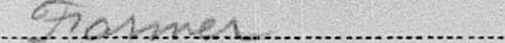

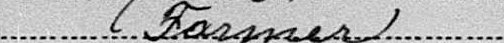

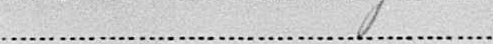

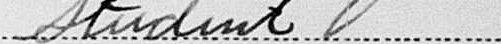

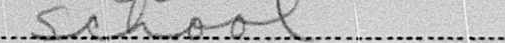

In [6]:
for i in get_random_data_points(5):
    display(i[0])

### First impressions
* The dataset has 100 data points.
* After running the exploration with a higher number of desired images, seems like there are several duplicated records.
* Most of the images shows tough handwriting.
* There are several blank images.
* All the images are in gray scale.

# Model Selections

My first approximation to this challenge will be explore and use models already crated and evaluate the output accuracy. Today, a good site to do a kickoff for a project is surf inside [Huggingface](https://huggingface.co/).

## TrOCRProcessor
I started ussing a Microsoft model called [TrOCRProcessor](https://huggingface.co/microsoft/trocr-base-handwritten) hosted on huggingface. It's a high used and supported model so it's a good starting point.

In [11]:
#Load Huggingface transformer
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

I want to load a random image from the snippet folder using the function already defined.<br/>
I will understand the output of the model to move fordward with the assestement requirements.

In [16]:
image = get_random_data_points(1)[0][0]

1} 007625955_007625955_00651_22.png


In [17]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [20]:
print(f'Predicted handwriting:{generated_text}')

Predicted handwriting:CLASSED REPORT


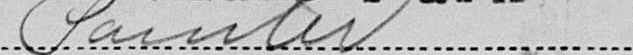

In [19]:
display(image)

### Preliminar conclusions
* For this randon snippet the prediction was pretty bad.
* The assignment requires the probability. Hence I need to extract the logits (aka row scores) from the model.
* After to do some extra stepts, maybe I will test another model.
* Another extra step could be to fintune this transformer getting data from other sources such as Kaggle.

### Next steps
* Extract the logits and convert it into probabilities.
* Create a general function to do inference.
* Save the requiered outputs for the whole snippets.
* Evaluate a little to get an idea about the precision of the model.

### Expected result
The results should be in a CSV file with the following columns:
* snippet_name
* label (the recognized text)
* confidence_score (a value between 0 and 1, like 0.78)

If any snippet is blank, it’s fine to leave the label and confidence_score fields empty.


In [19]:
def predict(model: VisionEncoderDecoderModel, image: Image)->list[str,int]:

    pixel_values = processor(images=image[0], return_tensors="pt").pixel_values


    # Use the generate() method to perform inference  
    generated_ids = model.generate(pixel_values)  
    
    # Decode the predicted text  
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  
    
    # If you want probabilities, you need to call the model directly  
    # Perform inference to get logits (raw scores)  
    outputs = model(pixel_values, decoder_input_ids=generated_ids, return_dict=True)  
    logits = outputs.logits 

    # Apply softmax to get probabilities  
    probs = F.softmax(logits, dim=-1)  

    # Decode the predicted text and get the most probable token IDs
    generated_ids = torch.argmax(logits, dim=-1)
    # Calculate confidence for each token  
    token_confidences = probs.max(dim=-1).values[0]  # Max probability for each token in the sequence  
    average_confidence = token_confidences.mean().item()
    """
    # Execute the inference for the image and get the logits  
    outputs = model(pixel_values, return_dict=True)  
    logits = outputs.logits

    # Apply softmax to get probabilities  
    probs = F.softmax(logits, dim=-1)  

    # Decode the predicted text and get the most probable token IDs
    generated_ids = torch.argmax(logits, dim=-1)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    """
    return(image[1], generated_text, average_confidence)

In [8]:
img = get_random_data_points(1)[0]

1} 007646580_007646580_01142_22.png


In [9]:
img

(<PIL.Image.Image image mode=RGB size=504x44>,
 '007646580_007646580_01142_22.png')

In [20]:
result = predict(model, img)

In [21]:
result

('007646580_007646580_01142_22.png',
 'Variety , before Allenville .',
 0.6036739349365234)

In [ ]:
007646218_007646218_00673_22.png
output:; '1961 62'

In [ ]:

PASOS QUE TENGO QUE HACER PARA SACAR LAS PROBABIKLIDADES DE PREDICCION

Extract the logits (raw scores) from the model.
Convert the logits into probabilities using the softmax function.

# Perform OCR and get logits  
outputs = model(pixel_values, return_dict=True)  
logits = outputs.logits  # Raw scores for each token  

# Apply softmax to get probabilities  
probs = F.softmax(logits, dim=-1)  

# Decode the predicted text  
generated_ids = torch.argmax(logits, dim=-1)  # Get the most probable token IDs  
recognized_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]  

print("Recognized Text:", recognized_text)  

# Example: Get probabilities for the first token  
first_token_probs = probs[0, 0]  # Probabilities for the first token  
print("Probabilities for the first token:", first_token_probs)  

In [ ]:
import easyocr  

# Initialize the EasyOCR reader  
reader = easyocr.Reader(['en'])  # Specify the language  

# Perform OCR on the image  
image_path = "handwritten_sample.jpg"  
result = reader.readtext(image_path)  

# Print the recognized text  
for detection in result:  
    print(detection[1])  # Extract the text part  

In [ ]:
import easyocr  

# Initialize the EasyOCR reader  
reader = easyocr.Reader(['en'])  # Specify the language  

# Perform OCR on the image  
image_path = "handwritten_sample.jpg"  
result = reader.readtext(image_path)  

# Print the recognized text with probabilities  
for detection in result:  
    text = detection[1]  # Extract the recognized text  
    confidence = detection[2]  # Extract the confidence score  
    print(f"Recognized Text: {text}, Confidence: {confidence:.2f}")  